In [ ]:

# Optional installs (only if you have internet access)
# !pip install --quiet torch torchvision torchmetrics

import os, random, math, sys
import numpy as np
from pathlib import Path

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
from PIL import Image


try:
    from torchmetrics.image.fid import FrechetInceptionDistance
    from torchmetrics.image.inception import InceptionScore
    _HAS_TORCHMETRICS = True
except Exception as e:
    _HAS_TORCHMETRICS = False
    _TM_ERR = str(e)


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.manual_seed(42); np.random.seed(42); random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:

PREFERRED_OUTPUT_DIR = r"D:\ESDS\summer 25\project\genai_benchmark\genai_benchmark\outputs"
if os.name == "nt" and Path(PREFERRED_OUTPUT_DIR).drive:  # running on Windows
    OUTPUT_DIR = PREFERRED_OUTPUT_DIR
else:
    OUTPUT_DIR = str(Path.cwd() / "outputs")

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)


DATASETS = {
    'MNIST':        {'channels': 1, 'image_size': 28} 
}

# Project-like hyperparams
SELECTED_DATASET = 'MNIST'   
EPOCHS = 30                
BATCH_SIZE = 64
LR = 1e-3
TIMESTEPS = 200
FID_SAMPLES = 64            
FID_MAX_IMAGES = 256         

print("OUTPUT_DIR:", OUTPUT_DIR)
print("DATASET:", SELECTED_DATASET)
print("DEVICE:", device)


OUTPUT_DIR: D:\ESDS\summer 25\project\genai_benchmark\genai_benchmark\outputs
DATASET: MNIST
DEVICE: cpu


In [10]:

def get_dataloader(dataset_name='MNIST', batch_size=64, train=True):
    if dataset_name == 'MNIST':
        tfm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # -> [-1, 1]
        ])
        ds = datasets.MNIST(root='./data', train=train, download=True, transform=tfm)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    return DataLoader(ds, batch_size=batch_size, shuffle=train)



In [11]:
def denorm(x):
    # x in [-1,1] -> [0,1]
    return (x.clamp(-1,1) + 1) / 2


In [12]:

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.linear = nn.Linear(dim, dim)

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(torch.linspace(math.log(1.0), math.log(1000.0), half, device=device))
        args = t.unsqueeze(1) * freqs  # (B, half)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return self.linear(emb)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.SiLU(),
        )
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))

    def forward(self, x, t_emb):
        h = self.net(x)
        b, c, _, _ = h.shape
        time_out = self.time_mlp(t_emb).view(b, c, 1, 1)
        return h + time_out

class SimpleUNet(nn.Module):
    def __init__(self, img_channels=1, base=32, time_dim=128):
        super().__init__()
        self.time_embed = SinusoidalTimeEmbedding(time_dim)

        self.down1 = DoubleConv(img_channels, base, time_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2, time_dim)
        self.pool2 = nn.MaxPool2d(2)

        self.mid = DoubleConv(base*2, base*2, time_dim)

        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_up2 = DoubleConv(base*2 + base*2, base, time_dim)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_up1 = DoubleConv(base + base, base, time_dim)

        self.final = nn.Conv2d(base, img_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_embed(t)
        d1 = self.down1(x, t_emb)
        d2 = self.down2(self.pool1(d1), t_emb)
        m  = self.mid(self.pool2(d2), t_emb)
        u2 = self.up2(m); u2 = torch.cat([u2, d2], dim=1); u2 = self.conv_up2(u2, t_emb)
        u1 = self.up1(u2); u1 = torch.cat([u1, d1], dim=1); u1 = self.conv_up1(u1, t_emb)
        return self.final(u1)


In [ ]:
def cosine_beta_schedule(timesteps, s=0.008, device="cpu"):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, device=device)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(1e-8, 0.999)


In [ ]:

class GaussianDiffusion:
    def __init__(self, model, timesteps=200, device='cpu'):
        self.model = model
        self.timesteps = timesteps
        self.device = device

       
        betas = cosine_beta_schedule(timesteps, device=device)          
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffers(betas, alphas, alphas_cumprod)


    def register_buffers(self, betas, alphas, alphas_cumprod):
        self.betas = betas
        self.alphas = alphas
        self.alphas_cumprod = alphas_cumprod
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=self.device), alphas_cumprod[:-1]], dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        sqrt_alpha_cum = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        xt = sqrt_alpha_cum * x0 + sqrt_one_minus * noise
        return xt, noise

    @torch.no_grad()
    def p_sample(self, x, t):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_cum = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_recip_alpha = self.sqrt_recip_alphas[t].view(-1, 1, 1, 1)

        # model predicts noise
        t_norm = t.float() / self.timesteps
        eps_theta = self.model(x, t_norm)

        # mean using predicted noise
        model_mean = sqrt_recip_alpha * (x - betas_t / sqrt_one_minus_cum * eps_theta)
        # if t == 0, just return mean
        if (t == 0).all():
            return model_mean
        
        noise = torch.randn_like(x)
        var = self.posterior_variance[t].view(-1, 1, 1, 1)
        return model_mean + torch.sqrt(var) * noise

    @torch.no_grad()
    def sample(self, image_size, channels=1, n=16):
        x = torch.randn(n, channels, image_size, image_size, device=self.device)
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((n,), t, dtype=torch.long, device=self.device)
            x = self.p_sample(x, t_tensor)
        return x

    @torch.no_grad()
    def sample_with_intermediate(self, image_size, channels=1, n=1, save_steps=(200,150,100,50,0)):
        """Return a list of (step, tensor) pairs for visualization, matching 'progression' style."""
        x = torch.randn(n, channels, image_size, image_size, device=self.device)
        frames = []
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((n,), t, dtype=torch.long, device=self.device)
            x = self.p_sample(x, t_tensor)
            if t in save_steps:
                frames.append((t, x.detach().clone().cpu()))
        return frames


In [ ]:

dataset_name = SELECTED_DATASET
cfg = DATASETS[dataset_name]
channels, image_size = cfg['channels'], cfg['image_size']


root_dir   = Path(OUTPUT_DIR)
sample_dir = root_dir / 'samples' / dataset_name
ckpt_dir   = root_dir / 'checkpoints' / dataset_name
fid_dir    = root_dir / 'fid_samples' / dataset_name
prog_dir   = root_dir / 'progression' / dataset_name
for p in [sample_dir, ckpt_dir, fid_dir, prog_dir]:
    p.mkdir(parents=True, exist_ok=True)


unet = SimpleUNet(img_channels=channels).to(device)
diffusion = GaussianDiffusion(unet, timesteps=TIMESTEPS, device=device)
opt = optim.Adam(unet.parameters(), lr=LR)
mse = nn.MSELoss()


dl = get_dataloader(dataset_name, batch_size=BATCH_SIZE, train=True)

epoch_losses = []
for epoch in range(1, EPOCHS + 1):
    unet.train()
    total_loss = 0.0
    for x, _ in dl:
        x = x.to(device)
        t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=device)
        xt, noise = diffusion.forward_diffusion(x, t)
        t_norm = t.float()/diffusion.timesteps
        noise_pred = unet(xt, t_norm)
        loss = mse(noise_pred, noise)

        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()

    avg = total_loss / len(dl)
    epoch_losses.append(avg)
    print(f"[{dataset_name}] Epoch {epoch}/{EPOCHS} - Loss: {avg:.4f}")

    
    unet.eval()
    with torch.no_grad():
        sample = diffusion.sample(image_size, channels=channels, n=16).cpu()
    vutils.save_image(sample, sample_dir / f"epoch_{epoch}.png", nrow=4, normalize=True)

    
    with torch.no_grad():
        frames = diffusion.sample_with_intermediate(image_size, channels=channels, n=1,
                                                    save_steps=set([TIMESTEPS-1, 150, 100, 50, 0]))
        
        imgs = [TF.resize(t[1].squeeze(0), 64) for t in frames]  # each t[1] is (1,C,H,W)
        grid = Image.new("RGB", (64*len(imgs), 64), "white")
        for i, tens in enumerate(imgs):
            grid.paste(TF.to_pil_image(tens).convert("RGB"), (i*64, 0))
        grid.save(prog_dir / f"progression_epoch_{epoch}.png")

    
    if epoch == EPOCHS:
        with torch.no_grad():
            for i in range(FID_SAMPLES):
                torch.manual_seed(i)
                out = diffusion.sample(image_size, channels=channels, n=1).cpu()
                vutils.save_image(out, fid_dir / f"sample_{i}.png", normalize=True)


torch.save(unet.state_dict(), ckpt_dir / "unet.pth")


plt.figure(figsize=(7,4))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title(f"{dataset_name} - MSE Loss per Epoch")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.grid(True); plt.tight_layout()
plt.savefig(sample_dir / "training_loss_curve.png"); plt.close()

print("Training done. Artifacts saved under:", root_dir)


[MNIST] Epoch 1/30 - Loss: 0.0860
[MNIST] Epoch 2/30 - Loss: 0.0558
[MNIST] Epoch 3/30 - Loss: 0.0499
[MNIST] Epoch 4/30 - Loss: 0.0469
[MNIST] Epoch 5/30 - Loss: 0.0459
[MNIST] Epoch 6/30 - Loss: 0.0446
[MNIST] Epoch 7/30 - Loss: 0.0439
[MNIST] Epoch 8/30 - Loss: 0.0433
[MNIST] Epoch 9/30 - Loss: 0.0430
[MNIST] Epoch 10/30 - Loss: 0.0426
[MNIST] Epoch 11/30 - Loss: 0.0419
[MNIST] Epoch 12/30 - Loss: 0.0417
[MNIST] Epoch 13/30 - Loss: 0.0417
[MNIST] Epoch 14/30 - Loss: 0.0414
[MNIST] Epoch 15/30 - Loss: 0.0413
[MNIST] Epoch 16/30 - Loss: 0.0413
[MNIST] Epoch 17/30 - Loss: 0.0411
[MNIST] Epoch 18/30 - Loss: 0.0409
[MNIST] Epoch 19/30 - Loss: 0.0406
[MNIST] Epoch 20/30 - Loss: 0.0405
[MNIST] Epoch 21/30 - Loss: 0.0405
[MNIST] Epoch 22/30 - Loss: 0.0402
[MNIST] Epoch 23/30 - Loss: 0.0400
[MNIST] Epoch 24/30 - Loss: 0.0400
[MNIST] Epoch 25/30 - Loss: 0.0399
[MNIST] Epoch 26/30 - Loss: 0.0401
[MNIST] Epoch 27/30 - Loss: 0.0396
[MNIST] Epoch 28/30 - Loss: 0.0397
[MNIST] Epoch 29/30 - Loss: 0

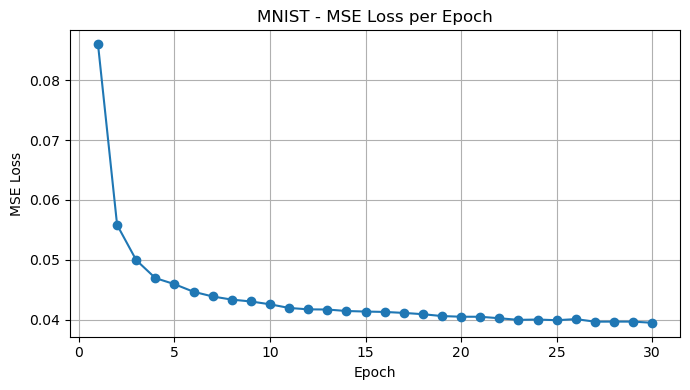

Saved loss curve to: D:\ESDS\summer 25\project\genai_benchmark\genai_benchmark\outputs\samples\MNIST\training_loss_curve.png


In [16]:

loss_curve_path = sample_dir / "training_loss_curve.png"

plt.figure(figsize=(7,4))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title(f"{dataset_name} - MSE Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig(loss_curve_path)
plt.show()  # optional
print("Saved loss curve to:", loss_curve_path)



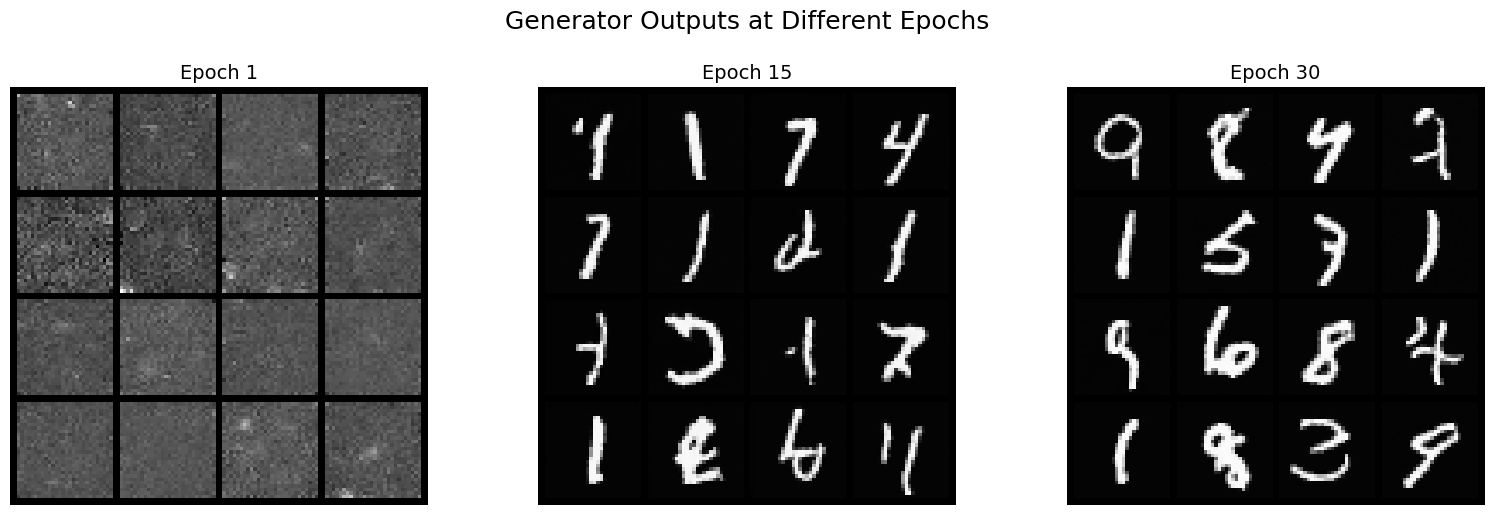

Saved: D:\ESDS\summer 25\project\genai_benchmark\genai_benchmark\outputs\samples\MNIST\epoch_comparison.png


In [ ]:

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# which epochs to show (1, middle, last)
epochs_to_show = sorted(set([1, max(1, EPOCHS // 2), EPOCHS]))

imgs = []
for e in epochs_to_show:
    p = sample_dir / f"epoch_{e}.png"
    if not p.exists():
        # find closest lower epoch that exists; otherwise skip
        cand = max([int(f.stem.split('_')[-1]) for f in sample_dir.glob("epoch_*.png") if f.is_file()])
        p = sample_dir / f"epoch_{cand}.png"
    imgs.append((e, Image.open(p).convert("RGB")))


fig_w = 16
fig, axes = plt.subplots(1, len(imgs), figsize=(fig_w, 5))
if len(imgs) == 1:
    axes = [axes]

fig.suptitle("Generator Outputs at Different Epochs", fontsize=18, y=1.02)

for ax, (e, im) in zip(axes, imgs):
    ax.imshow(im)
    ax.set_title(f"Epoch {e}", fontsize=14)
    ax.axis("off")

plt.tight_layout()
out_path = sample_dir / "epoch_comparison.png"
plt.savefig(out_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved:", out_path)


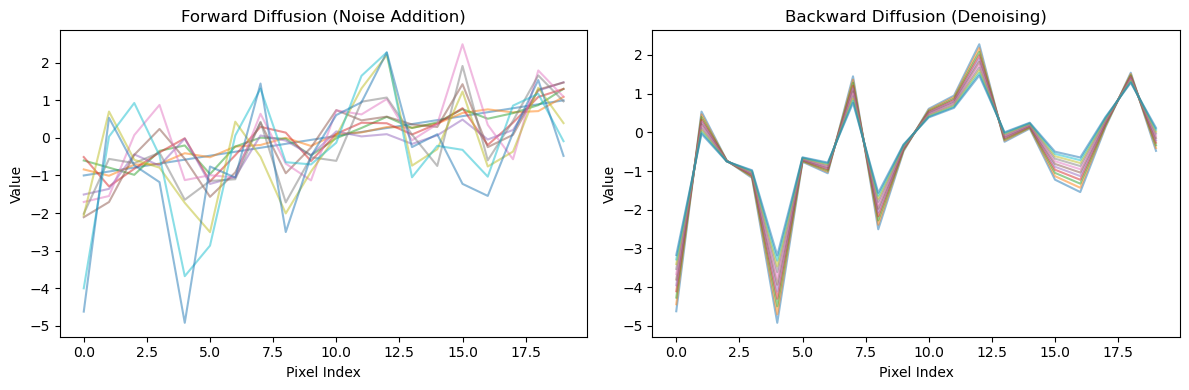

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


timesteps = 10
signal_length = 20


x0 = np.linspace(-1, 1, signal_length)


forward_steps = [x0]
x = x0.copy()
for t in range(timesteps):
    noise = np.random.randn(signal_length) * 0.1 * (t+1)  # increasing noise
    x = 0.95 * x + noise
    forward_steps.append(x)


backward_steps = [forward_steps[-1]]
x = forward_steps[-1].copy()
for t in reversed(range(timesteps)):
    # pretend to remove some noise each step
    x = x * 0.95 + 0.05 * x0
    backward_steps.append(x)


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for arr in forward_steps:
    axs[0].plot(arr, alpha=0.5)
axs[0].set_title("Forward Diffusion (Noise Addition)")
axs[0].set_xlabel("Pixel Index")
axs[0].set_ylabel("Value")

for arr in backward_steps:
    axs[1].plot(arr, alpha=0.5)
axs[1].set_title("Backward Diffusion (Denoising)")
axs[1].set_xlabel("Pixel Index")
axs[1].set_ylabel("Value")

plt.tight_layout()
plt.show()


In [ ]:
def compute_fid_and_is(generated_folder, batch_size=64, max_images=1000):
    if not _HAS_TORCHMETRICS:
        raise ImportError(f"torchmetrics unavailable: {_TM_ERR}\n"
                          "Install it with `pip install torchmetrics` and re-run this cell.")

    
    tfm_in = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # (1,H,W) -> (3,H,W)
    ])

    
    real_ds = datasets.MNIST(root='./data', train=True, download=True, transform=tfm_in)
    real_loader = DataLoader(real_ds, batch_size=batch_size, shuffle=True)

    real_images = []
    for imgs, _ in real_loader:
        real_images.append((imgs * 255).to(torch.uint8))
        if sum(x.size(0) for x in real_images) >= max_images:
            break
    real_images = torch.cat(real_images, dim=0)[:max_images]

    # Load generated images (already saved as RGB)
    gen_paths = sorted([p for p in Path(generated_folder).glob('*.png')])[:max_images]
    gen_images = []
    for p in gen_paths:
        img = Image.open(p).convert('RGB').resize((299, 299))
        gen_images.append(transforms.ToTensor()(img) * 255)
    if not gen_images:
        raise RuntimeError(f"No generated images found in {generated_folder}")
    gen_images = torch.stack(gen_images).to(torch.uint8)

    # FID
    fid = FrechetInceptionDistance(normalize=False)
    fid.update(real_images, real=True)
    fid.update(gen_images, real=False)
    fid_score = fid.compute().item()

    # Inception Score
    is_metric = InceptionScore(normalize=False)
    is_metric.update(gen_images)
    is_mean, is_std = is_metric.compute()

    return float(fid_score), float(is_mean), float(is_std)



In [ ]:


fid_folder = str(Path(OUTPUT_DIR) / 'fid_samples' / SELECTED_DATASET)

try:
    print(f"Evaluating MNIST from: {fid_folder}")
    fid, is_mean, is_std = compute_fid_and_is(
        generated_folder=fid_folder,
        batch_size=64,
        max_images=FID_MAX_IMAGES
    )
    print(f"[MNIST] FID: {fid:.2f}")
    print(f"[MNIST] IS : {is_mean:.2f} ± {is_std:.2f}")
except Exception as e:
    print("Evaluation skipped or failed:", e)
    print("Training artifacts were generated. Install torchmetrics and retry if needed.")



Evaluating MNIST from: D:\ESDS\summer 25\project\genai_benchmark\genai_benchmark\outputs\fid_samples\MNIST


c:\Users\LOKESH\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


[MNIST] FID: 107.39
[MNIST] IS : 1.59 ± 0.24


In [20]:
from tabulate import tabulate

summary_table = [
    ["Dataset", f"{SELECTED_DATASET} ({cfg['image_size']}x{cfg['image_size']})"],
    ["Epochs", str(EPOCHS)],
    ["Batch Size", str(BATCH_SIZE)],
    ["Model Architecture", "SimpleUNet"],
    ["Base Channels", "32"],
    ["Time Embedding Dim", "128"],
    ["Timesteps", str(TIMESTEPS)],
    ["Loss Function", "MSE Loss"],
    ["Optimizer", f"Adam (lr={LR}, β1=0.9, β2=0.999)"],
    ["Evaluation Metrics", "FID, Inception Score"],
]

print(tabulate(summary_table, headers=["Parameter", "Value"], tablefmt="github"))


| Parameter          | Value                             |
|--------------------|-----------------------------------|
| Dataset            | MNIST (28x28)                     |
| Epochs             | 30                                |
| Batch Size         | 64                                |
| Model Architecture | SimpleUNet                        |
| Base Channels      | 32                                |
| Time Embedding Dim | 128                               |
| Timesteps          | 200                               |
| Loss Function      | MSE Loss                          |
| Optimizer          | Adam (lr=0.001, β1=0.9, β2=0.999) |
| Evaluation Metrics | FID, Inception Score              |
